In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from collections import deque
import random
import matplotlib.pyplot as plt
import math

In [24]:
class HedgeEnvironment:
    """Simulates option hedging environment with trading costs"""
    
    def __init__(self, S0=100, K=100, T=10, sigma=0.01, r=0.0, D=5, cost_multiplier=5):
        # Environment parameters
        self.S0 = S0
        self.K = K
        self.T = T  # Days to maturity
        self.sigma = sigma  # Daily volatility
        self.r = r  # Risk-free rate
        self.D = D  # Periods per day
        self.cost_multiplier = cost_multiplier
        
        # State normalization parameters
        self.S_mean, self.S_std = S0, S0*0.1
        self.tau_mean, self.tau_std = T/2, T/3
        self.n_mean, self.n_std = 0, 50
        
        self.reset()
        
    def reset(self):
        """Reset environment to initial state"""
        self.S = self.S0
        self.t = 0
        self.total_steps = self.T * self.D
        self.n = 0  # Initial stock position
        self.option_value = self._bsm_price()
        return self._get_normalized_state()
    
    def _bsm_price(self):
        """Calculate option price using Black-Scholes (for simulation)"""
        tau = max((self.total_steps - self.t) / (self.D * 252), 1e-6)  # Time to expiry in years
        d1 = (np.log(self.S/self.K) + (self.r + 0.5*self.sigma**2)*tau) / (self.sigma*np.sqrt(tau))
        return self.S * 0.5 * (1 + math.erf(d1/np.sqrt(2))) - self.K * np.exp(-self.r*tau) * 0.5 * (1 + math.erf((d1 - self.sigma*np.sqrt(tau))/np.sqrt(2)))
    
    def _get_state(self):
        """Get raw state vector"""
        tau = (self.total_steps - self.t) / self.D  # Days remaining
        return np.array([self.S, tau, self.n], dtype=np.float32)
    
    def _get_normalized_state(self):
        """Get normalized state vector"""
        state = self._get_state()
        normalized = np.array([
            (state[0] - self.S_mean) / self.S_std,
            (state[1] - self.tau_mean) / self.tau_std,
            (state[2] - self.n_mean) / self.n_std
        ], dtype=np.float32)
        return normalized
    
    def _trading_cost(self, shares):
        """Calculate trading costs (spread + market impact)"""
        return self.cost_multiplier * 0.1 * (abs(shares) + 0.01 * shares**2)
    
    def step(self, action):
        """Execute one time step in environment"""
        # Convert action to integer shares (action is between -1 and 1)
        max_shares = 100
        shares = int(np.round(action * max_shares))
        
        # Calculate trading cost
        cost = self._trading_cost(shares)
        
        # Update position
        old_n = self.n
        self.n += shares
        
        # Simulate stock price movement
        old_S = self.S
        self.S *= np.exp((self.r - 0.5*self.sigma**2)*(1/self.D/252) + 
                         self.sigma*np.sqrt(1/self.D/252)*np.random.normal())
        self.t += 1
        
        # Calculate wealth change
        old_option_value = self.option_value
        self.option_value = self._bsm_price()
        
        delta_w = (self.n * (self.S - old_S) +  # Stock P&L
                  (self.option_value - old_option_value) * 100 +  # Option P&L (100 shares per contract)
                  -cost)  # Trading costs
        
        # Reward function (Equation 10 in paper)
        K = 0.1  # Risk aversion parameter
        reward = delta_w - (K/2) * delta_w**2
        
        # Check if episode is done
        done = self.t >= self.total_steps
        
        return self._get_normalized_state(), reward, done, {"delta_w": delta_w, "cost": cost, "shares": shares}

In [40]:
class DQNAgent:
    """Deep Q-Network agent for option hedging"""
    
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim
        
        # Experience replay buffer
        self.memory = deque(maxlen=100000)
        
        # Hyperparameters
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.update_target_every = 100  # Steps between target network updates
        
        # Networks
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.target_model.set_weights(self.model.get_weights())
        
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.loss_fn = tf.keras.losses.Huber(delta=1.0)
        
        # Tracking variables
        self.steps_since_target_update = 0
    
    def _build_model(self):

        model = models.Sequential([
            layers.Dense(32, activation='relu', input_dim=self.state_dim,
                        kernel_initializer='he_normal'),
            layers.BatchNormalization(),
            layers.Dense(32, activation='relu', 
                    kernel_initializer='he_normal'),
            layers.BatchNormalization(),
            layers.Dense(self.action_dim, 
                    kernel_initializer='he_normal')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        loss_fn = tf.keras.losses.Huber()
        model.compile(optimizer=optimizer, loss=loss_fn)
        return model
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Select action using ε-greedy policy"""
        if np.random.rand() <= self.epsilon:
            return np.random.uniform(-1, 1)  # Random action between -1 and 1
        
        state = np.expand_dims(state, axis=0)
        act_values = self.model.predict(state, verbose=0)
        return act_values[0][0]  # Single continuous action
    
    
    def replay(self):
    
        if len(self.memory) < self.batch_size:
            return

    # Sample batch from memory
        minibatch = random.sample(self.memory, self.batch_size)

        states = np.array([t[0] for t in minibatch])
        actions = np.array([t[1] for t in minibatch])
        rewards = np.array([t[2] for t in minibatch])
        next_states = np.array([t[3] for t in minibatch])
        dones = np.array([t[4] for t in minibatch])

    # Calculate target Q values using target network
        next_q_values = self.target_model.predict(next_states, verbose=0)
        max_next_q_values = np.max(next_q_values, axis=1)
        targets = rewards + self.gamma * max_next_q_values * (1 - dones)

    # Clip targets to prevent overflow
        targets = np.clip(targets, -100, 100)

    # Create mask for actions taken
        target_q_values = self.model.predict(states, verbose=0)
        target_q_values[range(self.batch_size), 0] = targets  # Update only the taken action

    # Train model
        self.model.fit(states, target_q_values, batch_size=self.batch_size, verbose=0)

    # Decay exploration rate
        if self.epsilon > self.epsilon_min:
             self.epsilon *= self.epsilon_decay

    # Update target network periodically
        self.steps_since_target_update += 1
        if self.steps_since_target_update >= self.update_target_every:
            self.target_model.set_weights(self.model.get_weights())
            self.steps_since_target_update = 0    
    
    def train(self, env, episodes=1000):
        """Train agent on environment"""
        rewards_history = []
        costs_history = []
        pnl_vol_history = []
        
        for e in range(episodes):
            state = env.reset()
            episode_rewards = []
            episode_costs = []
            episode_pnl = []
            
            for t in range(env.total_steps):
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                
                self.remember(state, action, reward, next_state, done)
                state = next_state
                
                episode_rewards.append(reward)
                episode_costs.append(info['cost'])
                episode_pnl.append(info['delta_w'])
                
                self.replay()
                
                if done:
                    break
            
            # Calculate metrics for episode
            total_reward = np.sum(episode_rewards)
            total_cost = np.sum(episode_costs)
            pnl_vol = np.std(episode_pnl)
            
            rewards_history.append(total_reward)
            costs_history.append(total_cost)
            pnl_vol_history.append(pnl_vol)
            
            if e % 10 == 0:
                print(f"Episode {e+1}/{episodes}, Reward: {total_reward:.2f}, Cost: {total_cost:.2f}, PnL Vol: {pnl_vol:.2f}, ε: {self.epsilon:.3f}")
        
        return rewards_history, costs_history, pnl_vol_history

In [41]:
# Initialize environment and agent
env = HedgeEnvironment()
state_dim = 3
action_dim = 1  # Continuous action space (-1 to 1)

agent = DQNAgent(state_dim, action_dim)

# Train agent
rewards, costs, pnl_vols = agent.train(env, episodes=200)

# Plot training results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 3, 2)
plt.plot(costs)
plt.title('Trading Costs')
plt.xlabel('Episode')
plt.ylabel('Total Cost')

plt.subplot(1, 3, 3)
plt.plot(pnl_vols)
plt.title('PnL Volatility')
plt.xlabel('Episode')
plt.ylabel('Std Dev of PnL')

plt.tight_layout()
plt.show()

/Users/simonshen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1/200, Reward: -9605.51, Cost: 2186.37, PnL Vol: 33.46, ε: 1.000
Episode 11/200, Reward: -1288234502.18, Cost: 784959.51, PnL Vol: 16381.20, ε: 0.087
Episode 21/200, Reward: -357250777405.22, Cost: 18348674.14, PnL Vol: 87268.80, ε: 0.010
Episode 31/200, Reward: -611714688134.40, Cost: 24769828.93, PnL Vol: 10232.28, ε: 0.010
Episode 41/200, Reward: -611171295650.44, Cost: 24433611.20, PnL Vol: 69472.92, ε: 0.010
Episode 51/200, Reward: -618685200244.18, Cost: 24895673.80, PnL Vol: 7971.61, ε: 0.010
Episode 61/200, Reward: -622715978517.26, Cost: 24983053.01, PnL Vol: 8923.65, ε: 0.010
Episode 71/200, Reward: -600573998605.33, Cost: 24071637.90, PnL Vol: 99315.10, ε: 0.010
Episode 81/200, Reward: -634896151732.63, Cost: 25142848.94, PnL Vol: 8511.98, ε: 0.010
Episode 91/200, Reward: -630581671367.51, Cost: 25129577.21, PnL Vol: 8642.57, ε: 0.010
Episode 101/200, Reward: -631203050064.17, Cost: 25133891.41, PnL Vol: 8919.49, ε: 0.010
Episode 111/200, Reward: -624795033808.69, Co

Traceback (most recent call last):
  File "/Users/simonshen/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/ff/lnl5tqlx17q32s219m3285600000gn/T/ipykernel_13514/3905893816.py", line 9, in <module>
    rewards, costs, pnl_vols = agent.train(env, episodes=200)
  File "/var/folders/ff/lnl5tqlx17q32s219m3285600000gn/T/ipykernel_13514/826818456.py", line 123, in train
    self.replay()
  File "/var/folders/ff/lnl5tqlx17q32s219m3285600000gn/T/ipykernel_13514/826818456.py", line 76, in replay
    next_q_values = self.target_model.predict(next_states, verbose=0)
  File "/Users/simonshen/Library/Python/3.9/lib/python/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/Users/simonshen/Library/Python/3.9/lib/python/site-packages/keras/src/backend/tensorflow/trainer.py", line 557, in predict
    for step, i

/var/folders/ff/lnl5tqlx17q32s219m3285600000gn/T/ipykernel_13514/3536762296.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([delta_rewards, rl_rewards], labels=['Delta', 'RL'])
/var/folders/ff/lnl5tqlx17q32s219m3285600000gn/T/ipykernel_13514/3536762296.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([delta_costs, rl_costs], labels=['Delta', 'RL'])
/var/folders/ff/lnl5tqlx17q32s219m3285600000gn/T/ipykernel_13514/3536762296.py:68: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([delta_vols, rl_vols], labels=['Delta', 'RL'])


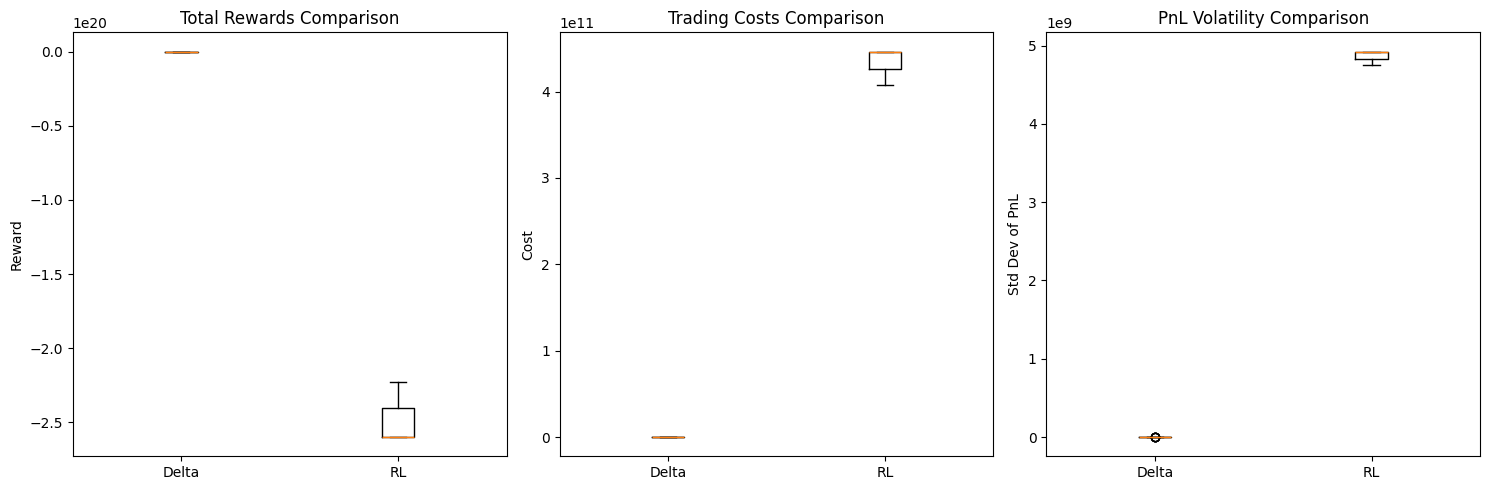

In [31]:
def delta_hedge_policy(env):
    """Baseline delta hedging policy"""
    # Calculate BSM delta
    tau = max((env.total_steps - env.t) / (env.D * 252), 1e-6)
    d1 = (np.log(env.S/env.K) + (env.r + 0.5*env.sigma**2)*tau) / (env.sigma*np.sqrt(tau))
    delta = 0.5 * (1 + math.erf(d1/np.sqrt(2)))
    
    # Target position is -100 * delta (1 option contract = 100 shares)
    target_shares = -100 * delta
    
    # Action is difference between target and current position
    action = (target_shares - env.n) / 100  # Normalize to [-1, 1] range
    
    return action

def evaluate_policy(env, policy, n_episodes=100):
    """Evaluate a policy on the environment"""
    total_rewards = []
    total_costs = []
    pnl_vols = []
    
    for _ in range(n_episodes):
        state = env.reset()
        episode_rewards = []
        episode_costs = []
        episode_pnl = []
        
        for t in range(env.total_steps):
            if policy == 'delta':
                action = delta_hedge_policy(env)
            else:  # RL policy
                action = agent.act(state)
            
            next_state, reward, done, info = env.step(action)
            state = next_state
            
            episode_rewards.append(reward)
            episode_costs.append(info['cost'])
            episode_pnl.append(info['delta_w'])
            
            if done:
                break
        
        total_rewards.append(np.sum(episode_rewards))
        total_costs.append(np.sum(episode_costs))
        pnl_vols.append(np.std(episode_pnl))
    
    return total_rewards, total_costs, pnl_vols

# Evaluate both policies
rl_rewards, rl_costs, rl_vols = evaluate_policy(env, 'rl')
delta_rewards, delta_costs, delta_vols = evaluate_policy(env, 'delta')

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.boxplot([delta_rewards, rl_rewards], labels=['Delta', 'RL'])
plt.title('Total Rewards Comparison')
plt.ylabel('Reward')

plt.subplot(1, 3, 2)
plt.boxplot([delta_costs, rl_costs], labels=['Delta', 'RL'])
plt.title('Trading Costs Comparison')
plt.ylabel('Cost')

plt.subplot(1, 3, 3)
plt.boxplot([delta_vols, rl_vols], labels=['Delta', 'RL'])
plt.title('PnL Volatility Comparison')
plt.ylabel('Std Dev of PnL')

plt.tight_layout()
plt.show()